In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import scienceplots

In [30]:
plt.style.use(["science", "no-latex", "grid"])
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors[0] = "#3498db"
colors[1] = "#2ecc71"
dark_colors = ["#2980b9", "#27ae60"]
width_in_pt = 418.25368
height_in_pt = width_in_pt * 0.75
plt.rcParams['figure.figsize'] = width_in_pt / 72.0, height_in_pt / 72.0

avg_linestyle = '--'
scatter_size = 0.1
scatter_color = colors[3]
scatter_zorder = 9

In [3]:
def rising_edge(data, threshold):
    sign = data >= threshold
    pos = np.where(np.convolve(sign, [1, -1]) == 1)
    return pos[0]
def calculate_power_consumption(threshold,df,plt, first_edge=2,last_edge=6):
    x_high = rising_edge(df['Reading'], threshold)
    i_start_integral = x_high[first_edge]
    i_end_integral = x_high[last_edge]
    plt.axvline(x=df['Time'].iloc[i_start_integral], color='black', linestyle='--')
    plt.legend(loc='lower right')
    plt.axvline(x=df['Time'].iloc[i_end_integral], color='black', linestyle='--')
    plt.legend(loc='lower right')
    ###integral
    integral = np.trapz(df['Reading'].iloc[i_start_integral:i_end_integral],df['Time'].iloc[i_start_integral:i_end_integral])
    watt = integral*5.0
    print("power consumption:",watt,"mW","total time:",df['Time'].iloc[i_end_integral]-df['Time'].iloc[i_start_integral],"s")
    total_time = df['Time'].iloc[i_end_integral]-df['Time'].iloc[i_start_integral]
    return (watt,total_time)

# Blank measures
## TODO : 
- colors
- labels
- legend position

Difference between the averages: 1.867mA


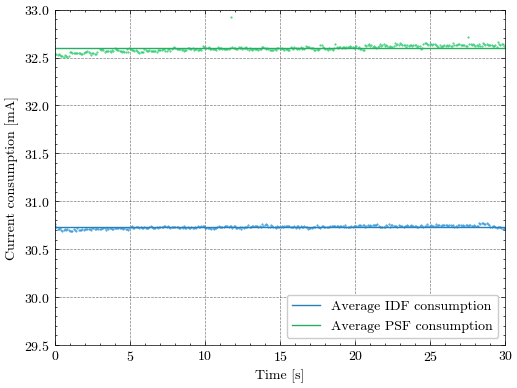

In [4]:

# Preprocessing IDF
df = pd.read_csv('05_03/idf_blank.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df = df[df['Time']>(pd.to_datetime('14:25:18')-start).total_seconds()]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<30]
blank_avg = df['Reading'].mean()
# np.round(df.diff()['Time'].mean(),5) # 0.08265 = average time between two measures

# Preprocessing 2W
df2 = pd.read_csv('05_03/priv_40M_sums_kernel_whitout_user.csv',header=7)
df2['Reading'] = df2['Reading']*1000.0
df2['Time'] = pd.to_datetime(df2['Time'], format='mixed')
start  = df2['Time'].min()
df2['Time'] = df2['Time'] - start
df2['Time'] = df2['Time'].dt.total_seconds()
df2["Time"] = df2["Time"] + df2["Fractional Seconds"]
df2 = df2[df2['Time']>(pd.to_datetime('15:00:42')-start).total_seconds()]
df2['Time'] = df2['Time'] - df2['Time'].min()
df2 = df2[['Time','Reading']]
df2 = df2[df2['Reading']<35]
df2.reset_index(inplace=True, drop=True)
df2['Time'] = [i * 0.08265 for i in range(len(df2))]
df2 = df2[df2['Time'] < 30]
w2_avg = df2['Reading'].mean()

# Plotting
plt.scatter(df['Time'],df['Reading'], color=colors[0], s=0.25)
plt.axhline(y=blank_avg, color=dark_colors[0], linestyle='-',label='Average IDF consumption')

plt.scatter(df2['Time'],df2['Reading'], color=colors[1], s=0.25)
plt.axhline(y=w2_avg, color=dark_colors[1], linestyle='-',label='Average PSF consumption')

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(29.5,33)
plt.xlim(0,30)
plt.grid(True)

# Export
plt.savefig('output/pdf/blank.pdf')
plt.savefig('output/png/blank.png')

print(f'Difference between the averages: {np.round(w2_avg-blank_avg, 3)}mA')

# CPU intensive computations

## IDF

power consumption: 4096.393285899048 mW total time: 20.2441091 s
Sample rate : 1/0.010711677142857144s
Measures above the average : 1554
Measures below the average : 1247
Steps : 14
Average computation time: 1.19 s
Std of computation time: 0.23 s
Average idle time: 0.95 s
Std of idle time: 0.15 s


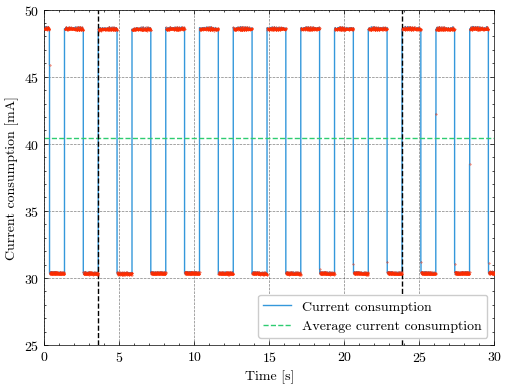

In [5]:
# Preprocessing
df = pd.read_csv('05_10/idf_sum_40m.csv',header=8)
df['Reading'] = df['Reading']*1000.0
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<30]
avg = df['Reading'].mean()


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1], linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 50)
plt.xlim(0,30)
plt.grid(True)
calculate_power_consumption(45,df,plt,2,11)

# Export
plt.savefig('output/pdf/sum_idf.pdf')
plt.savefig('output/png/sum_idf.png')

# Compute the average computation time and idle time
sample_rate = df.diff()['Time'].mean()
n_above = len(df[df['Reading'] > avg])
n_below = len(df[df['Reading'] < avg])
print(f"Sample rate : 1/{sample_rate}s")
print(f"Measures above the average : {n_above}")
print(f"Measures below the average : {n_below}")

# Initialize lists to store computation and idle times
computation_times = []
idle_times = []

steps = 1
current_computation_time = 0
current_idle_time = 0

for i in range(1, len(df)):
    if df['Reading'][i] > avg:
        if df['Reading'][i-1] <= avg:
            if current_idle_time > 0:
                idle_times.append(current_idle_time * sample_rate)
                current_idle_time = 0
            steps += 1
        current_computation_time += 1
    else:
        if df['Reading'][i-1] > avg:
            if current_computation_time > 0:
                computation_times.append(current_computation_time * sample_rate)
                current_computation_time = 0
        current_idle_time += 1

# Handle the last segment
if current_computation_time > 0:
    computation_times.append(current_computation_time * sample_rate)
if current_idle_time > 0:
    idle_times.append(current_idle_time * sample_rate)

# Calculate means and standard deviations
mean_computation_time = np.mean(computation_times)
std_computation_time = np.std(computation_times)
mean_idle_time = np.mean(idle_times)
std_idle_time = np.std(idle_times)

print(f"Steps : {steps}")
print(f'Average computation time: {np.round(mean_computation_time, 2)} s')
print(f'Std of computation time: {np.round(std_computation_time, 2)} s')
print(f'Average idle time: {np.round(mean_idle_time, 2)} s')
print(f'Std of idle time: {np.round(std_idle_time, 2)} s')

## 2W - Kernel

power consumption: 4180.959504115305 mW total time: 20.248620980000002 s
Sample rate : 1/0.08264738005524862s
Measures above the average : 206
Measures below the average : 157
Steps : 14
Average computation time: 1.21 s
Std of computation time: 0.13 s
Average idle time: 1.0 s
Std of idle time: 0.02 s


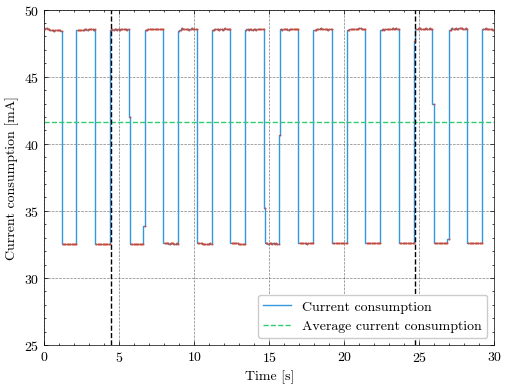

In [6]:
# Preprocessing
df = pd.read_csv('05_03/priv_40M_sums_kernel_whitout_user.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<30]
avg = df['Reading'].mean()
df.reset_index(drop=True, inplace=True)


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1], linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 50)
plt.xlim(0,30)
plt.grid(True)
calculate_power_consumption(45,df,plt,2,11)

# Export
plt.savefig('output/pdf/sum_kernel.pdf')
plt.savefig('output/png/sum_kernel.png')

# Compute the average computation time and idle time
sample_rate = df.diff()['Time'].mean()
n_above = len(df[df['Reading'] > avg])
n_below = len(df[df['Reading'] < avg])
print(f"Sample rate : 1/{sample_rate}s")
print(f"Measures above the average : {n_above}")
print(f"Measures below the average : {n_below}")

# Initialize lists to store computation and idle times
computation_times = []
idle_times = []

steps = 1
current_computation_time = 0
current_idle_time = 0

for i in range(1, len(df)):
    if df['Reading'][i] > avg:
        if df['Reading'][i-1] <= avg:
            if current_idle_time > 0:
                idle_times.append(current_idle_time * sample_rate)
                current_idle_time = 0
            steps += 1
        current_computation_time += 1
    else:
        if df['Reading'][i-1] > avg:
            if current_computation_time > 0:
                computation_times.append(current_computation_time * sample_rate)
                current_computation_time = 0
        current_idle_time += 1

# Handle the last segment
if current_computation_time > 0:
    computation_times.append(current_computation_time * sample_rate)
if current_idle_time > 0:
    idle_times.append(current_idle_time * sample_rate)

# Calculate means and standard deviations
mean_computation_time = np.mean(computation_times)
std_computation_time = np.std(computation_times)
mean_idle_time = np.mean(idle_times)
std_idle_time = np.std(idle_times)

print(f"Steps : {steps}")
print(f'Average computation time: {np.round(mean_computation_time, 2)} s')
print(f'Std of computation time: {np.round(std_computation_time, 2)} s')
print(f'Average idle time: {np.round(mean_idle_time, 2)} s')
print(f'Std of idle time: {np.round(std_idle_time, 2)} s')

## 2W - User

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


power consumption: 4200.565617154448 mW total time: 20.24808928 s
Sample rate : 1/0.08264473174515236s
Measures above the average : 205
Measures below the average : 157
Steps : 14
Average computation time: 1.2 s
Std of computation time: 0.13 s
Average idle time: 1.0 s
Std of idle time: 0.02 s


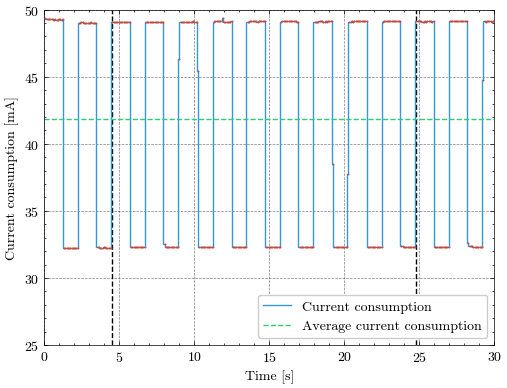

In [7]:
# Preprocessing
df = pd.read_csv('05_03/priv_40M_sums_user.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
calculate_power_consumption(45,df,plt,2,11)

df = df[df['Time']<30]
avg = df['Reading'].mean()
df = df.drop(df.index[0])
df.reset_index(drop=True, inplace=True)


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 50)
plt.xlim(0,30)
plt.grid(True)

# Export
plt.savefig('output/pdf/sum_user.pdf')
plt.savefig('output/png/sum_user.png')

# Compute the average computation time and idle time
sample_rate = df.diff()['Time'].mean()
n_above = len(df[df['Reading'] > avg])
n_below = len(df[df['Reading'] < avg])
print(f"Sample rate : 1/{sample_rate}s")
print(f"Measures above the average : {n_above}")
print(f"Measures below the average : {n_below}")

# Initialize lists to store computation and idle times
computation_times = []
idle_times = []

steps = 1
current_computation_time = 0
current_idle_time = 0

for i in range(1, len(df)):
    if df['Reading'][i] > avg:
        if df['Reading'][i-1] <= avg:
            if current_idle_time > 0:
                idle_times.append(current_idle_time * sample_rate)
                current_idle_time = 0
            steps += 1
        current_computation_time += 1
    else:
        if df['Reading'][i-1] > avg:
            if current_computation_time > 0:
                computation_times.append(current_computation_time * sample_rate)
                current_computation_time = 0
        current_idle_time += 1

# Handle the last segment
if current_computation_time > 0:
    computation_times.append(current_computation_time * sample_rate)
if current_idle_time > 0:
    idle_times.append(current_idle_time * sample_rate)

# Calculate means and standard deviations
mean_computation_time = np.mean(computation_times)
std_computation_time = np.std(computation_times)
mean_idle_time = np.mean(idle_times)
std_idle_time = np.std(idle_times)

print(f"Steps : {steps}")
print(f'Average computation time: {np.round(mean_computation_time, 2)} s')
print(f'Std of computation time: {np.round(std_computation_time, 2)} s')
print(f'Average idle time: {np.round(mean_idle_time, 2)} s')
print(f'Std of idle time: {np.round(std_idle_time, 2)} s')

## 2W - Syscall

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


power consumption: 9570.51548111613 mW total time: 48.75665824 s
Sample rate : 1/0.08263766762430938s
Measures above the average : 301
Measures below the average : 62
Steps : 6
Average computation time: 4.13 s
Std of computation time: 0.59 s
Average idle time: 1.02 s
Std of idle time: 0.04 s


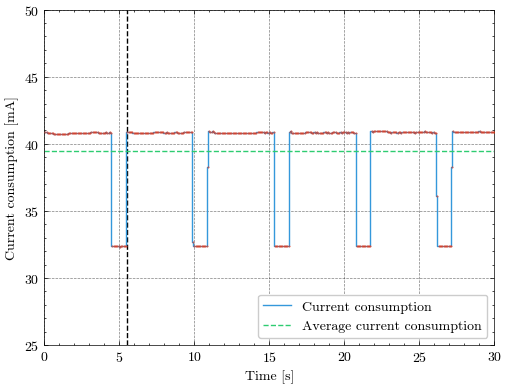

In [8]:
# Preprocessing
df = pd.read_csv('05_03/priv_1M_sums_sys.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
calculate_power_consumption(40,df,plt,1,10)

df = df[df['Time']<30]
avg = df['Reading'].mean()
df = df.drop(df.index[0])
df.reset_index(drop=True, inplace=True)


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 50)
plt.xlim(0,30)
plt.grid(True)

# Export
plt.savefig('output/pdf/sum_syscall.pdf')
plt.savefig('output/png/sum_syscall.png')

# Compute the average computation time and idle time
sample_rate = df.diff()['Time'].mean()
n_above = len(df[df['Reading'] > avg])
n_below = len(df[df['Reading'] < avg])
print(f"Sample rate : 1/{sample_rate}s")
print(f"Measures above the average : {n_above}")
print(f"Measures below the average : {n_below}")

# Initialize lists to store computation and idle times
computation_times = []
idle_times = []

steps = 1
current_computation_time = 0
current_idle_time = 0

for i in range(1, len(df)):
    if df['Reading'][i] > avg:
        if df['Reading'][i-1] <= avg:
            if current_idle_time > 0:
                idle_times.append(current_idle_time * sample_rate)
                current_idle_time = 0
            steps += 1
        current_computation_time += 1
    else:
        if df['Reading'][i-1] > avg:
            if current_computation_time > 0:
                computation_times.append(current_computation_time * sample_rate)
                current_computation_time = 0
        current_idle_time += 1

# Handle the last segment
if current_computation_time > 0:
    computation_times.append(current_computation_time * sample_rate)
if current_idle_time > 0:
    idle_times.append(current_idle_time * sample_rate)

# Calculate means and standard deviations
mean_computation_time = np.mean(computation_times)
std_computation_time = np.std(computation_times)
mean_idle_time = np.mean(idle_times)
std_idle_time = np.std(idle_times)

print(f"Steps : {steps}")
print(f'Average computation time: {np.round(mean_computation_time, 2)} s')
print(f'Std of computation time: {np.round(std_computation_time, 2)} s')
print(f'Average idle time: {np.round(mean_idle_time, 2)} s')
print(f'Std of idle time: {np.round(std_idle_time, 2)} s')

# Multitask
## Full use
### IDF

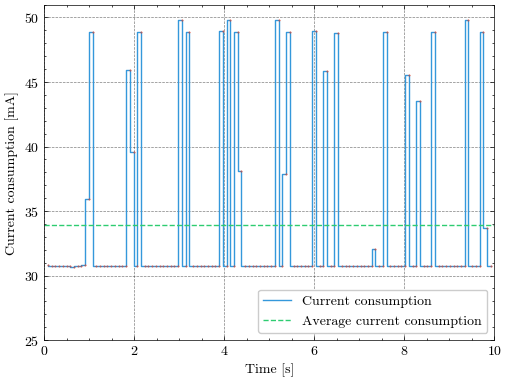

In [9]:
# Preprocessing
df = pd.read_csv('05_03/idf_multitask_1M_2M_3M.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<10]
avg = df['Reading'].mean()
df = df.drop(df.index[0])


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 51)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/multi_full_idf.pdf')
plt.savefig('output/png/multi_full_idf.png')

### 2W

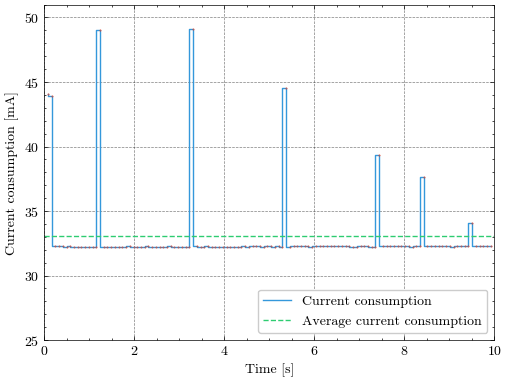

In [10]:
# Preprocessing
df = pd.read_csv('05_03/priv_multitask_1M_2M_3M.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<10]
avg = df['Reading'].mean()
# print(np.round(df.diff()['Time'].mean(),5))
df = df.drop(df.index[0])


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 51)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/multi_full_2w.pdf')
plt.savefig('output/png/multi_full_2w.png')

## Cooperative Scheduling
### IDF

Average current consumption: 40.473064091598275 mA


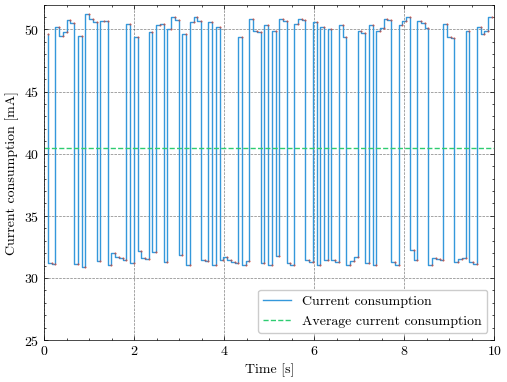

In [11]:
# Preprocessing
df = pd.read_csv('05_10/idf_1m_2m_3m.csv',header=8)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<10]
avg = df['Reading'].mean()
# print(np.round(df.diff()['Time'].mean(),5)) # 0.00051 -> samples ~ 162x faster
df = df.iloc[::162]
df = df.drop(df.index[0])


# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 52)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/multi_coop_idf.pdf')
plt.savefig('output/png/multi_coop_idf.png')

print(f"Average current consumption: {avg} mA")

### 2W

Average current consumption: 47.87738369850541 mA


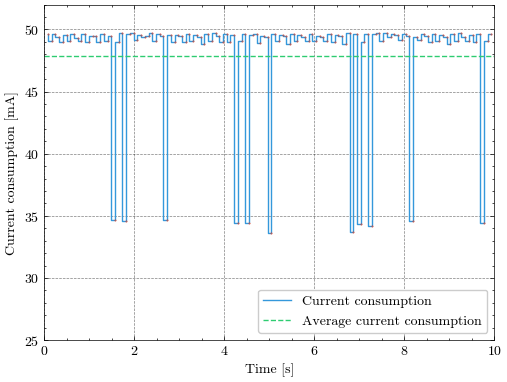

In [12]:
# Preprocessing
df = pd.read_csv('05_10/preemption_1m_2m_3m.csv',header=8)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<10]
avg = df['Reading'].mean()
# print(np.round(df.diff()['Time'].mean(),5)) # 0.00051 -> samples ~ 162x faster
df = df.iloc[::162]
df = df.drop(df.index[0])

# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(25, 52)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/multi_coop_2w.pdf')
plt.savefig('output/png/multi_coop_2w.png')

print(f"Average current consumption: {avg} mA")

## Deep sleep

0.02452
Average current consumption: 17.349742097731163 mA


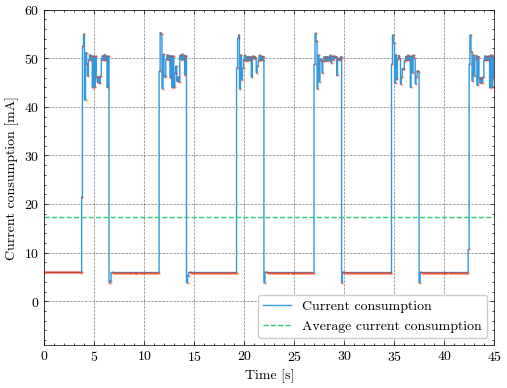

In [13]:
# Preprocessing
df = pd.read_csv('05_15/2w_deep_sleep.csv',header=8)
df['Reading'] = df['Reading']*1000.0
# df = df[df['Reading']>5.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']<90]
df = df[df['Time']>5]
avg = df['Reading'].mean()
print(np.round(df.diff()['Time'].mean(),5)) # 0.02452 -> samples ~ 162x faster
df = df.iloc[::4]
df = df.drop(df.index[0])
df["Time"] = df["Time"] - df["Time"].iloc[0]
# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(-9, 60)
plt.xlim(0,45)
plt.grid(True)


# Export
plt.savefig('output/pdf/multi_deep_2w.pdf')
plt.savefig('output/png/multi_deep_2w.png')

print(f"Average current consumption: {avg} mA")

##

# WiFi
## IDF

Average *idle* current consumption: 34.80503016284571 mA
Average current consumption: 42.39553474813487 mA


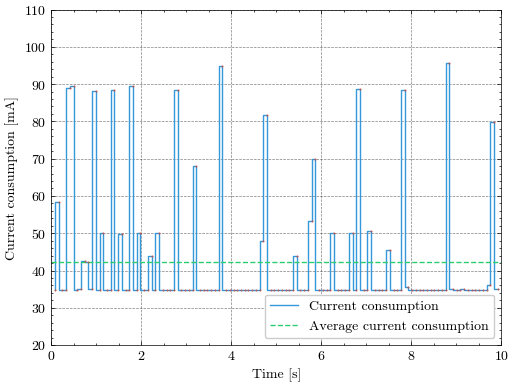

In [14]:
# Preprocessing
df = pd.read_csv('05_03/idf_wifi_send.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']>1]
df = df[df['Time']<11]
avg = df['Reading'].mean()
df['Time'] = df['Time'] - df['Time'].min()
df = df.drop(df.index[0])

# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(20, 110)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/wifi_idf.pdf')
plt.savefig('output/png/wifi_idf.png')

idle = df[df['Reading'] < 40]
print(f'Average *idle* current consumption: {idle["Reading"].mean()} mA')
print(f'Average current consumption: {avg} mA')

## 2W

Average *idle* current consumption: 36.836959968010405 mA
Average current consumption: 51.89735599416314 mA


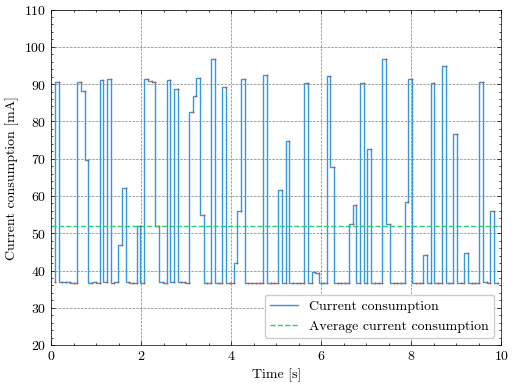

In [15]:
# Preprocessing
df = pd.read_csv('05_03/priv_wifi_full_app.csv',header=7)
df['Reading'] = df['Reading']*1000.0
df = df[df['Reading']>30.0]
df = df[df['Reading']<110.0]
df['Time'] = pd.to_datetime(df['Time'], format='mixed')
start  = df['Time'].min()
df['Time'] = df['Time'] - start
df['Time'] = df['Time'].dt.total_seconds()
df["Time"] = df["Time"] + df["Fractional Seconds"]
df['Time'] = df['Time'] - df['Time'].min()
df = df[['Time','Reading']]
df = df[df['Time']>4]
df = df[df['Time']<14]
avg = df['Reading'].mean()
df['Time'] = df['Time'] - df['Time'].min()

df = df.drop(df.index[0])

# Plotting
plt.step(df['Time'],df['Reading'],color=colors[0], label='Current consumption')
plt.scatter(df['Time'],df['Reading'],color=scatter_color, s=scatter_size, zorder=scatter_zorder)
plt.axhline(y=avg, color=colors[1],linestyle=avg_linestyle,label='Average current consumption')
plt.grid(True)

plt.legend(loc='lower right')
plt.xlabel('Time [s]')
plt.ylabel('Current consumption [mA]')
plt.ylim(20, 110)
plt.xlim(0,10)
plt.grid(True)

# Export
plt.savefig('output/pdf/wifi_2w.pdf')
plt.savefig('output/png/wifi_2w.png')

idle = df[df['Reading'] < 40]
print(f'Average *idle* current consumption: {idle["Reading"].mean()} mA')
print(f'Average current consumption: {avg} mA')

# NVS Reading benchmark

In [31]:
temp_colors = colors
temp_colors[0] = colors[3]
temp_colors[1] = dark_colors[1]
temp_colors[3] = dark_colors[0]# temp_colors = temp_colors[::-1]

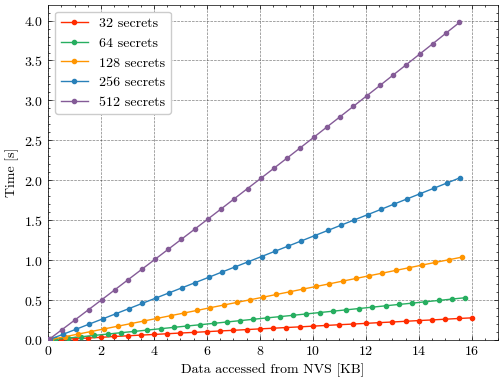

In [32]:
data = {}
# add all csvs from the 05_18 folder to data dictionary
for file in os.listdir('05_18'):
    if file.endswith('.csv'):
        df = pd.read_csv(f'05_18/{file}')
        data[int(file.split("_")[0])] = df

current = 0
full_size = 16384

for n_secrets, df in sorted(data.items()):
    # df['value'] = (df['value']+1)*full_size/n_secrets
    div = int(len(df['value'])/32)
    df = df.iloc[::div]
    plt.plot((df['value']+1)*full_size/n_secrets/1024,df['time']/1000, color=temp_colors[current],linestyle='-', marker='.', label=f'{n_secrets} secrets', zorder=scatter_zorder)
    # plt.scatter((df['value']+1)*full_size/n_secrets/1024,df['time']/1000, color=colors[current], s=0.3, zorder=scatter_zorder)
    
    current += 1
    

legend = plt.legend(loc='upper left')
# Adjust the legend marker size
for handle in legend.legend_handles:
    handle._sizes = [10]  # Change this value to the desired marker size

plt.ylabel('Time [s]')
plt.xlabel('Data accessed from NVS [KB]')
plt.ylim(0, 4.2)
plt.xlim(0,17)
xticks = np.arange(0, 16384 + 1024, 1024)
plt.grid(True)
plt.savefig('output/pdf/nvs_read.pdf')
plt.savefig('output/png/nvs_read.png')
# print(data)